In [1]:
# imports
import os
import sys
import time
import json
# add to the path the source files
sys.path.append(os.path.dirname(os.getcwd()))

import wandb
import pandas as pd
from copy import deepcopy
from dgl.data.utils import load_graphs
import dgl
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GINConv, GCNConv, global_add_pool, JumpingKnowledge
import torch_geometric 
#from torch_geometric.loader import DataLoader
import networkx as nx
from src.dataset.counting_algorithm import subgraph_counting
from src.baseline.model_gcn import GCN, GIN
from src.ppgn.ppgn import PPGN
from src.baseline.dataset_gcn import GraphDataset
from src.metrics.L1_based import L1LossCount, L1LossStd
from matplotlib import pyplot as plt
from torch_geometric.utils import dropout_adj, to_dense_adj, to_dense_batch, degree
from torch_geometric.nn import GatedGraphConv
from torch_scatter import scatter_mean, scatter_add
import numpy as np
import random
from src.I2GNN.I2GNN import I2GNN
from src.I2GNN.I2GNN_dataset import I2GNNDataset, I2GNNDataLoader
from src.I2GNN.utils import create_subgraphs2

def generate_gnn_input(graph: nx.Graph, device)->torch_geometric.data.Data:
    """Creates from a networkx graph a Data instance, which is the input a a pytorch geometric model."""
    x = torch.ones(graph.number_of_nodes(), 1) # no improovement by using more channels in the first layer
    edge_index = torch.empty(2, graph.number_of_edges(), dtype=torch.long)
    for i, edge in enumerate(graph.edges()):
        edge_index[0,i] = edge[0]
        edge_index[1,i] = edge[1]
    return torch_geometric.data.Data(x=x, edge_index=edge_index).to(device)

def train_epoch(gin, dataloader, loss_fn, optimizer, device):
    gin.train()
    tot_loss = 0.
    for data in dataloader:
        #print(len(data.batch.unique()))
        optimizer.zero_grad()
        data = data.to(device)
        y = data.y
        
        pred = gin(data)#.flatten()
        loss = loss_fn(pred, y)
        tot_loss += loss
      
        loss.backward()
        optimizer.step()
    return tot_loss/len(dataloader)

def eval_epoch(gin, dataloader, loss_fn, device):
    gin.eval()
    n = 0
    with torch.no_grad():
        loss = 0.
        for data in dataloader:
            data = data.to(device)
            y = data.y
            pred = gin(data)#.flatten()
            l = loss_fn(pred, y)
            loss += l * data.num_graphs
            n += data.num_graphs
            
        loss = loss / n
    return loss

The device used is :cuda
Batch(node_to_subgraph2=[1395131], edge_index=[2, 3589546], center_idx=[212109, 2], z=[1395131, 1], subgraph2_to_subgraph=[212109], num_nodes=1395131, num_subgraphs=[1500], node_to_original_node=[1395131], num_original_nodes=[1500], subgraph_to_graph=[45000], subgraph2_to_graph=[212109], y=[1500, 1])
1500
standard deviation: tensor([7.8882])
mean: tensor([21.0424])
{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'params': [0, 1]}, {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'params': [2, 3]}, {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'params': [4, 5]}]}
Loss at epoch 0: train: 15.76725959777832, eval train 8.206957817077637 , validatio

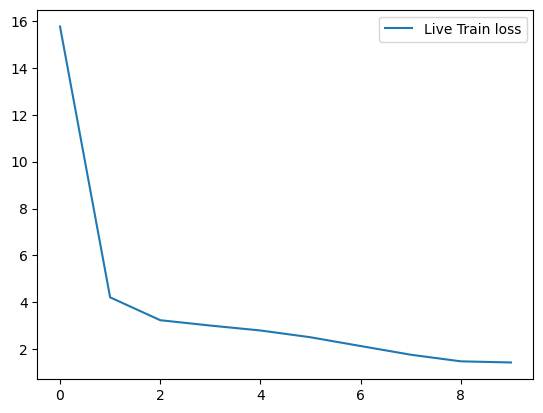

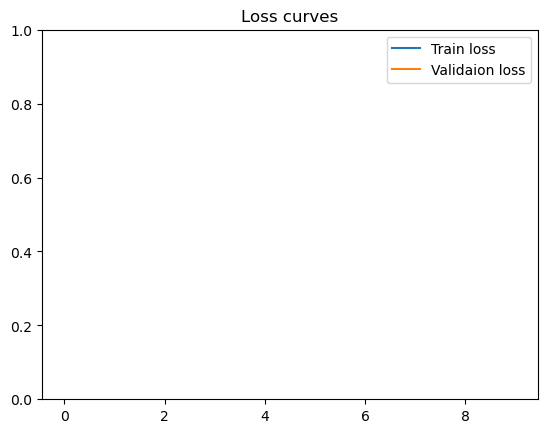

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f"The device used is :{device}")

patience = 50
lr = 1e-3
channels = [1, 128, 64]
num_lay = 4
pooling = 'add'
aggr = 'add'
jk = None#'cat'
batch_size = 64
batch_norm = True
task = 'Triangle'
dropout = 0.
concat = True
depth_of_mlp = 2
act = 'elu'
hops = 1

torch.manual_seed(0)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

def pre_transform(g, hops):
    return create_subgraphs2(g, hops)

train_dataset = I2GNNDataset(root="/nfs/students/campi/dataset/training",dataset="train_5000_sbm_30.bin",  subgraph_type=task, pre_transform=pre_transform, hops=hops)
val_dataset = I2GNNDataset(root="/nfs/students/campi/dataset/training",dataset="validation_5000_sbm_30.bin",  subgraph_type=task, pre_transform=pre_transform, hops=hops)
print(train_dataset.data)
print(len(train_dataset.data.num_subgraphs))
y_train_val = torch.cat([train_dataset.data.y, val_dataset.data.y], dim=0)
mean = y_train_val.mean(dim=0)
std = y_train_val.std(dim=0)

print(f"standard deviation: {std}")
print(f"mean: {mean}")

dataloader = I2GNNDataLoader(dataset=train_dataset, batch_size=batch_size)
dataloader_val = I2GNNDataLoader(dataset=val_dataset, batch_size=batch_size)
h_params = {'in_channels': channels[0], 'hidden_channels': channels[1], 'act': act, 'out_channels': channels[2], 'num_layers':num_lay, 'pooling':pooling,  'aggr':aggr, 'concat':concat}

gnn = I2GNN(num_layers=5).to(device)

loss_fn =  torch.nn.L1Loss()
loss_fn_eval = torch.nn.L1Loss() #L1LossStd(std)
#optimizer = torch.optim.Adam(params=gnn.parameters(), lr=lr)
optimizer = torch.optim.Adam(params=[{'params' :gnn.fc1.parameters()}, 
                                     {'params' :gnn.fc2.parameters()}, 
                                     {'params' :gnn.fc3.parameters()}], lr=lr)
# optimizer.add_param_group(gnn.fc2.parameters())
# optimizer.add_param_group(gnn.fc3.parameters())
print(optimizer.state_dict())
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor = 5e-1, patience=100)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

val_losses = []
train_losses = []
live_train_losses = []
best_val = 1000000000
checkpoint = gnn.state_dict()
waiting = 0
for epoch in range(10):
    start = time.time()
    loss = train_epoch(gnn, dataloader, loss_fn, optimizer, device)
    live_train_losses.append(loss.cpu().item())
    train_loss = eval_epoch(gnn, dataloader, loss_fn_eval, device)
    train_losses.append(train_loss.cpu())
    val_loss = eval_epoch(gnn, dataloader_val, loss_fn_eval, device)
    val_losses.append(val_loss.cpu())

    scheduler.step()
    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        waiting = 0
        checkpoint = deepcopy(gnn.state_dict())
    else:
        waiting += 1
    if waiting == patience:
        break
        
    print(f"Loss at epoch {epoch}: train: {loss}, eval train {train_loss} , validation: {val_loss},\ttime required: {time.time() - start}")


print(f"Metrics fo the best model: {best_val}")
epochs = list(range(epoch+1))
plt.plot(epochs, live_train_losses, label="Live Train loss")
plt.legend()
plt.show()
plt.plot(epochs, train_losses, label="Train loss")
# plt.legend()
# plt.show()
plt.plot(epochs, val_losses, label="Validaion loss")
plt.title("Loss curves")
plt.ylim((0,1))
plt.legend()
plt.show()

torch.save(gnn.state_dict(), "model.pth")
with open('model.json', "w") as fp:
    json.dump(h_params,fp)


The device used is :cuda
standard deviation: 3.0613481998443604
Loss at epoch 0: train: 24.345333099365234, eval train 1.3460040092468262 , validation: 1.3978694677352905,	time required: 0.25028395652770996
Loss at epoch 1: train: 3.652320623397827, eval train 1.1615374088287354 , validation: 1.227299690246582,	time required: 0.24625706672668457
Loss at epoch 2: train: 3.537386417388916, eval train 1.1232361793518066 , validation: 1.1876567602157593,	time required: 0.2549290657043457
Loss at epoch 3: train: 3.466923475265503, eval train 1.1102689504623413 , validation: 1.171197772026062,	time required: 0.27408409118652344
Loss at epoch 4: train: 3.3862693309783936, eval train 1.0790934562683105 , validation: 1.1401257514953613,	time required: 0.2702634334564209
Loss at epoch 5: train: 3.290393829345703, eval train 1.0231162309646606 , validation: 1.0858488082885742,	time required: 0.26505112648010254
Loss at epoch 6: train: 3.100294828414917, eval train 0.8975445628166199 , validation:

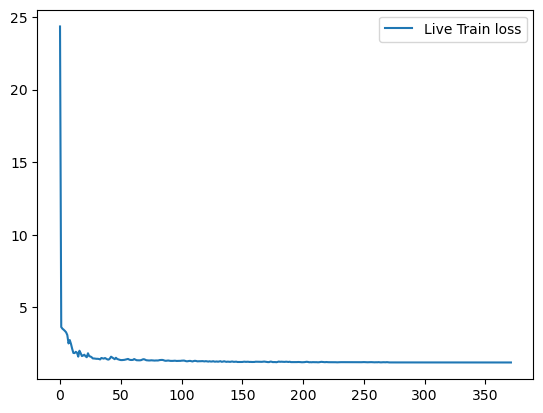

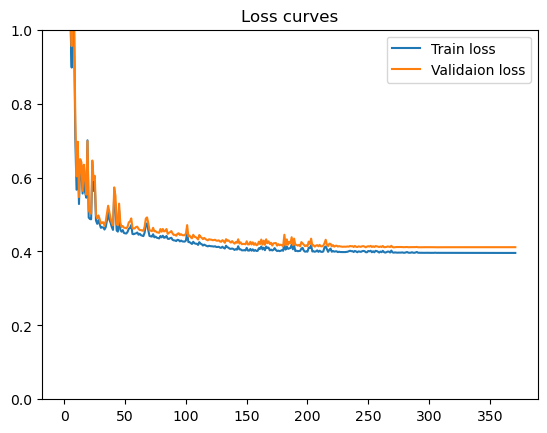

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f"The device used is :{device}")

patience = 100
lr = 1e-2
channels = [1, 128, 64]
num_lay = 3
pooling = 'add'
aggr = 'add'
jk = None#'cat'
batch_size = 128
batch_norm = True
task = 'triangle'
dropout = 0.
concat = True
depth_of_mlp = 2
act = 'relu'

torch.manual_seed(1)


# train_dataset = GraphDataset(dataset_path="/nfs/students/campi/dataset/training/train_10000_er_50.bin", task=task, in_channels=channels[0])
train_dataset = GraphDataset(dataset_path="/nfs/students/campi/dataset/training/train_dataset_2.bin", task=task, in_channels=channels[0])

# val_dataset = GraphDataset(dataset_path="/nfs/students/campi/dataset/training/validation_10000_er_50.bin", task=task, in_channels=channels[0])
val_dataset = GraphDataset(dataset_path="/nfs/students/campi/dataset/training/validation_dataset_2.bin", task=task, in_channels=channels[0])

std = torch.cat([train_dataset.labels, val_dataset.labels]).std()
print(f"standard deviation: {std}")

dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
dataloader_val = DataLoader(dataset=val_dataset, batch_size=batch_size)
#gnn = PPGN(in_channels=channels[0], hidden_channels=channels[1], out_channels=channels[2], num_layers=num_lay, act='relu', pooling=pooling, concat=concat, depth_of_mlp=depth_of_mlp).to(device)
gnn = GIN(in_channels=channels[0], hidden_channels=channels[1], out_channels=channels[2], num_layers=num_lay, pooling=pooling,  aggr=aggr, concat=concat, act=act).to(device)

loss_fn =  torch.nn.L1Loss()
loss_fn_eval = L1LossStd(std)
optimizer = torch.optim.Adam(params=gnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor = 5e-1, patience=20)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)



val_losses = []
train_losses = []
live_train_losses = []
best_val = 1000000000
checkpoint = gnn.state_dict()
waiting = 0
for epoch in range(500):
    start = time.time()
    loss = train_epoch(gnn, dataloader, loss_fn, optimizer, device)
    live_train_losses.append(loss.cpu().item())
    train_loss = eval_epoch(gnn, dataloader, loss_fn_eval, device)
    train_losses.append(train_loss.cpu())
    val_loss = eval_epoch(gnn, dataloader_val, loss_fn_eval, device)
    val_losses.append(val_loss.cpu())

    scheduler.step(val_loss)
    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        waiting = 0
        checkpoint = deepcopy(gnn.state_dict())
    else:
        waiting += 1
    if waiting == patience:
        break
        
    print(f"Loss at epoch {epoch}: train: {loss}, eval train {train_loss} , validation: {val_loss},\ttime required: {time.time() - start}")


print(f"Metrics fo the best model: {best_val}")
epochs = list(range(epoch+1))
plt.plot(epochs, live_train_losses, label="Live Train loss")
plt.legend()
plt.show()
plt.plot(epochs, train_losses, label="Train loss")
# plt.legend()
# plt.show()
plt.plot(epochs, val_losses, label="Validaion loss")
plt.title("Loss curves")
plt.ylim((0,1))
plt.legend()
plt.show()

#torch.save(gin, "model_pgnn.pkl")

In [3]:
test_dataset = GraphDataset(dataset_path="data/dataset2.bin", task=task, in_channels=channels[0])
with open("data/dataset2_test.txt") as f:
    test_idx = [int(idx) for idx in f.readlines()]
test_dataset.data = [test_dataset.data[i] for i in train_idx]
test_dataset.labels = test_dataset.labels[train_idx]
dataloader_test = DataLoader(dataset=test_dataset, batch_size=batch_size)

loss_fn_eval = torch.nn.L1Loss()
gnn.load_state_dict(checkpoint)
test_loss = eval_epoch(gnn, dataloader_test, loss_fn_eval, device)
print(f"Test loss: {test_loss}")

/nfs/homedirs/campi/miniconda3/envs/thesis/lib/python3.7/site-packages/dgl/data/graph_serialize.py:179: DGLWarning: You are loading a graph file saved by old version of dgl.              Please consider saving it again with the current format.
  Please consider saving it again with the current format.")


NameError: name 'train_idx' is not defined

In [ ]:
from torch_geometric.utils import to_dense_adj, to_dense_batch
import dgl
import os
import torch

graphs, counts = dgl.load_graphs("/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/tests/data/dataset2.bin")

with open("/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/tests/data/dataset2_train.txt") as f:
    train_idx = [int(idx) for idx in f.readlines()]
train_graphs = [graphs[i] for i in train_idx]
train_counts = {}
for key in counts.keys():
    train_counts[key] = counts[key][train_idx]
    train_counts[key] = torch.unsqueeze(train_counts[key], dim=1)

with open("/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/tests/data/dataset2_val.txt") as f:
    val_idx = [int(idx) for idx in f.readlines()]
val_graphs = [graphs[i] for i in val_idx]
val_counts = {}
for key in counts.keys():
    val_counts[key] = counts[key][val_idx]
    val_counts[key] = torch.unsqueeze(val_counts[key], dim=1)

with open("/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/tests/data/dataset2_test.txt") as f:
    test_idx = [int(idx) for idx in f.readlines()]
test_graphs = [graphs[i] for i in test_idx]
test_counts = {}
for key in counts.keys():
    test_counts[key] = counts[key][test_idx]
    test_counts[key] = torch.unsqueeze(test_counts[key], dim=1)

data_paht = '/home/francesco/Desktop/Master thesis/robustness-of-subgraphs-count/data/training'
dgl.save_graphs(os.path.join(data_paht, 'train_dataset_2.bin'), train_graphs, train_counts)
dgl.save_graphs(os.path.join(data_paht, 'validation_dataset_2.bin'), val_graphs, val_counts)
dgl.save_graphs(os.path.join(data_paht, 'test_dataset_2.bin'), test_graphs, test_counts)
